# Data Loading - Utah FORGE Well Data

**Project:** Pilot AI Drill - ROP Prediction Model  
**Phase:** 1 - Data Processing  
**Notebook:** 01_data_loading.ipynb  

---

## Objective

Load and perform initial validation of LAS file data from Utah FORGE Well 16-16B(78)-32.

**Scope:**
- Load .LAS file using `welly` library
- Extract relevant features (operational + geological)
- Validate data quality (nulls, negatives, continuity)
- Export clean DataFrame to CSV
- Save metadata for reproducibility

**Out of Scope (for next notebook):**
- Exploratory Data Analysis (EDA)
- Statistical analysis
- Feature engineering

---

In [1]:
# Standard libraries
import os
import json
from datetime import datetime

# Data manipulation
import pandas as pd
import numpy as np

# LAS file handling
import welly
from welly import Well

# Visualization (minimal for this notebook)
import matplotlib.pyplot as plt
import seaborn as sns


/home/luis-cm/Documents/Github/pilot-ai-drill/.venv/lib/python3.10/site-packages/welly/__init__.py:69: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [2]:

# Configure pandas display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Configure matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
# matplotlib inline

print("Libraries loaded successfully")
print(f"Welly version: {welly.__version__}")
print(f"Pandas version: {pd.__version__}")

Libraries loaded successfully
Welly version: 0.5.2
Pandas version: 2.3.3


## 1. File Validation

In [3]:
# Define file path
LAS_FILE_PATH = '../data/raw/Utah_Forge_16B(78)-32_6_19a.las'

# Validate file exists
if not os.path.exists(LAS_FILE_PATH):
    raise FileNotFoundError(f"❌ LAS file not found: {LAS_FILE_PATH}")

# Get file info
file_size_mb = os.path.getsize(LAS_FILE_PATH) / (1024 * 1024)
file_modified = datetime.fromtimestamp(os.path.getmtime(LAS_FILE_PATH))

print("=" * 60)
print("FILE INFORMATION")
print("=" * 60)
print(f"File found: {LAS_FILE_PATH}")
print(f"File size: {file_size_mb:.2f} MB")

FILE INFORMATION
File found: ../data/raw/Utah_Forge_16B(78)-32_6_19a.las
File size: 7.11 MB


## 2. Load LAS File

In [4]:
# Load LAS file into Well object
well = Well.from_las(LAS_FILE_PATH)

print("=" * 60)
print("WELL INFORMATION")
print("=" * 60)
print(f"Well Name: {well.name}")
print(f"Number of Curves: {len(well.data)}")

# Extract key information from header
start_depth = well.header.loc[well.header['mnemonic'] == 'STRT', 'value'].values[0]
stop_depth = well.header.loc[well.header['mnemonic'] == 'STOP', 'value'].values[0]
step = well.header.loc[well.header['mnemonic'] == 'STEP', 'value'].values[0]
null_value = well.header.loc[well.header['mnemonic'] == 'NULL', 'value'].values[0]

print(f"Depth Range: {start_depth} - {stop_depth} ft")
print(f"Step: {step} ft")
print(f"NULL Value: {null_value}")

# Display available curves
print("\n" + "=" * 60)
print("AVAILABLE CURVES")
print("=" * 60)
for i, curve in enumerate(well.data.keys(), 1):
    print(f"{i:2d}. {curve}")

WELL INFORMATION
Well Name: Frontier_16-16B(78)-32(Frontier_16-16B(78)-32)
Number of Curves: 37
Depth Range: 90.0 - 10947.5 ft
Step: 1.0 ft
NULL Value: -999.25

AVAILABLE CURVES
 1. WOBI
 2. TQI
 3. RPMI
 4. ROPA
 5. ANH
 6. CAL
 7. CHL
 8. EPI
 9. HEM
10. PYR
11. QTZ
12. SER
13. SIL
14. LPT
15. MTIA
16. MTOA
17. AH2S3
18. AH2S4
19. AH2S2
20. AH2S1
21. UNKNOWN:1
22. UNKNOWN:2
23. UNKNOWN:3
24. UNKNOWN:4
25. UNKNOWN:5
26. UNKNOWN:6
27. UNKNOWN:7
28. UNKNOWN:8
29. UNKNOWN:9
30. UNKNOWN:10
31. UNKNOWN:11
32. UNKNOWN:12
33. UNKNOWN:13
34. UNKNOWN:14
35. UNKNOWN:15
36. UNKNOWN:16
37. UNKNOWN:17


## 3. Remap Mnemonics

Map non-standard mnemonics to standard names for better compatibility.

In [5]:
# Define remapping dictionary
REMAP = {
    'DMEA': 'DEPT',    # Depth (measured)
    'WOBI': 'WOB',     # Weight on Bit
    'TQI': 'TORQUE',   # Torque
    'RPMI': 'RPM',     # Revolutions per Minute
    'ROPA': 'ROP'      # Rate of Penetration (TARGET)
}

# Validate remapping keys exist
missing_curves = [key for key in REMAP.keys() if key not in well.data.keys()]
if missing_curves:
    print(f"[WARNING] Missing curves for remapping: {missing_curves}")
else:
    print("All remapping curves found in LAS file")

# Reload with remapping
well = Well.from_las(LAS_FILE_PATH, remap=REMAP)
df_well = well.df()

print(f"\nDataFrame shape: {df_well.shape}")
print(f"Memory usage: {df_well.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

[WARNING] Missing curves for remapping: ['DMEA']

DataFrame shape: (10857, 37)
Memory usage: 3.15 MB


/home/luis-cm/Documents/Github/pilot-ai-drill/.venv/lib/python3.10/site-packages/welly/curve.py:470: FutureWarning: Index.is_numeric is deprecated. Use pandas.api.types.is_any_real_numeric_dtype instead
  if self.df.index.is_numeric() and not self.df.index.empty:


In [6]:
df_well

,WOBI,TQI,RPMI,ROPA,ANH,CAL,CHL,EPI,HEM,PYR,QTZ,SER,SIL,LPT,MTIA,MTOA,AH2S3,AH2S4,AH2S2,AH2S1,UNKNOWN:1,UNKNOWN:2,UNKNOWN:3,UNKNOWN:4,UNKNOWN:5,UNKNOWN:6,UNKNOWN:7,UNKNOWN:8,UNKNOWN:9,UNKNOWN:10,UNKNOWN:11,UNKNOWN:12,UNKNOWN:13,UNKNOWN:14,UNKNOWN:15,UNKNOWN:16,UNKNOWN:17
DEPT,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
90.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN
91.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN
92.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN
93.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN
94.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10942.00,55.03,20.55,83.79,198.00,NaN,NaN,10.00,10.00,NaN,NaN,50.00,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,100.00,0.00,102.72,120.91,0.10,0.30,0.20,0.10
10943.00,55.08,20.70,82.75,194.51,NaN,NaN,10.00,10.00,NaN,NaN,50.00,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,100.00,0.00,102.72,120.91,0.10,0.40,0.20,0.10
10944.00,55.26,20.85,82.21,202.20,NaN,NaN,10.00,10.00,NaN,NaN,50.00,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,100.00,0.00,102.72,120.84,0.10,0.40,0.20,0.20


## 4. Select Relevant Columns

Keep only operational, geological, and environmental features. Remove UNKNOWN columns.

In [7]:
# Define feature groups
OPERATIONAL_FEATURES = ['WOBI', 'TQI', 'RPMI', 'ROPA', 'MTIA', 'MTOA']
GEOLOGICAL_FEATURES = ['ANH', 'CAL', 'CHL', 'EPI', 'HEM', 'PYR', 'QTZ', 'SER', 'SIL', 'LPT']
ENVIRONMENTAL_FEATURES = ['AH2S1', 'AH2S2', 'AH2S3', 'AH2S4']

# Combine all features
COLUMNS_TO_KEEP = OPERATIONAL_FEATURES + GEOLOGICAL_FEATURES + ENVIRONMENTAL_FEATURES

# Filter DataFrame
df_well = df_well[COLUMNS_TO_KEEP]

print("=" * 60)
print("FEATURE SELECTION")
print("=" * 60)
print(f"Operational features: {len(OPERATIONAL_FEATURES)}")
print(f"Geological features: {len(GEOLOGICAL_FEATURES)}")
print(f"Environmental features: {len(ENVIRONMENTAL_FEATURES)}")
print(f"\nTotal features selected: {len(COLUMNS_TO_KEEP)}")
print(f"New DataFrame shape: {df_well.shape}")

FEATURE SELECTION
Operational features: 6
Geological features: 10
Environmental features: 4

Total features selected: 20
New DataFrame shape: (10857, 20)


## 5. Rename Columns

Use descriptive names with units for clarity.

In [8]:
# Define column mapping with units
COLUMN_MAPPING = {
    # Operational parameters
    'WOBI': 'weight_on_bit_klb',
    'TQI': 'torque_ftlb',
    'RPMI': 'rpm',
    'ROPA': 'rop_ft_hr',  # TARGET VARIABLE
    'MTIA': 'mud_temp_in_f',
    'MTOA': 'mud_temp_out_f',
    
    # Geological features (minerals)
    'ANH': 'anhydrite_pct',
    'CAL': 'calcite_pct',
    'CHL': 'chlorite_pct',
    'EPI': 'epidote_pct',
    'HEM': 'hematite_pct',
    'PYR': 'pyrite_pct',
    'QTZ': 'quartz_pct',
    'SER': 'sericite_pct',
    'SIL': 'sill_pct',
    'LPT': 'lithology_pct',
    
    # Environmental (H2S monitoring)
    'AH2S1': 'h2s_shakers_ppm',
    'AH2S2': 'h2s_rig_floor_ppm',
    'AH2S3': 'h2s_cellar_ppm',
    'AH2S4': 'h2s_pits_ppm'
}

# Rename columns
df_well = df_well.rename(columns=COLUMN_MAPPING)

# Reset index to make DEPTH a column
df_well = df_well.reset_index()
df_well = df_well.rename(columns={'DEPT': 'depth_ft'})

print("Columns renamed with descriptive names and units")
print(f"\nColumn names:")
for i, col in enumerate(df_well.columns, 1):
    print(f"{i:2d}. {col}")

Columns renamed with descriptive names and units

Column names:
 1. depth_ft
 2. weight_on_bit_klb
 3. torque_ftlb
 4. rpm
 5. rop_ft_hr
 6. mud_temp_in_f
 7. mud_temp_out_f
 8. anhydrite_pct
 9. calcite_pct
10. chlorite_pct
11. epidote_pct
12. hematite_pct
13. pyrite_pct
14. quartz_pct
15. sericite_pct
16. sill_pct
17. lithology_pct
18. h2s_shakers_ppm
19. h2s_rig_floor_ppm
20. h2s_cellar_ppm
21. h2s_pits_ppm


## 6. Data Overview

In [9]:
# Display DataFrame info
print("=" * 60)
print("DATAFRAME INFORMATION")
print("=" * 60)
df_well.info()

# Display first and last rows
print("\n" + "=" * 60)
print("FIRST 5 ROWS")
print("=" * 60)
display(df_well.head())

print("\n" + "=" * 60)
print("LAST 5 ROWS")
print("=" * 60)
display(df_well.tail())

DATAFRAME INFORMATION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10857 entries, 0 to 10856
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   depth_ft           10857 non-null  float64
 1   weight_on_bit_klb  10041 non-null  float64
 2   torque_ftlb        9258 non-null   float64
 3   rpm                10041 non-null  float64
 4   rop_ft_hr          10041 non-null  float64
 5   mud_temp_in_f      10857 non-null  float64
 6   mud_temp_out_f     10857 non-null  float64
 7   anhydrite_pct      555 non-null    float64
 8   calcite_pct        2840 non-null   float64
 9   chlorite_pct       1404 non-null   float64
 10  epidote_pct        1063 non-null   float64
 11  hematite_pct       1691 non-null   float64
 12  pyrite_pct         9 non-null      float64
 13  quartz_pct         9036 non-null   float64
 14  sericite_pct       28 non-null     float64
 15  sill_pct           0 non-null      float64
 16  

,depth_ft,weight_on_bit_klb,torque_ftlb,rpm,rop_ft_hr,mud_temp_in_f,mud_temp_out_f,anhydrite_pct,calcite_pct,chlorite_pct,epidote_pct,hematite_pct,pyrite_pct,quartz_pct,sericite_pct,sill_pct,lithology_pct,h2s_shakers_ppm,h2s_rig_floor_ppm,h2s_cellar_ppm,h2s_pits_ppm
0,90.00,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00
1,91.00,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00
2,92.00,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00
3,93.00,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00
4,94.00,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00



LAST 5 ROWS


,depth_ft,weight_on_bit_klb,torque_ftlb,rpm,rop_ft_hr,mud_temp_in_f,mud_temp_out_f,anhydrite_pct,calcite_pct,chlorite_pct,epidote_pct,hematite_pct,pyrite_pct,quartz_pct,sericite_pct,sill_pct,lithology_pct,h2s_shakers_ppm,h2s_rig_floor_ppm,h2s_cellar_ppm,h2s_pits_ppm
10852,10942.00,55.03,20.55,83.79,198.00,0.00,0.00,NaN,NaN,10.00,10.00,NaN,NaN,50.00,NaN,NaN,0.00,0.00,0.00,0.00,0.00
10853,10943.00,55.08,20.70,82.75,194.51,0.00,0.00,NaN,NaN,10.00,10.00,NaN,NaN,50.00,NaN,NaN,0.00,0.00,0.00,0.00,0.00
10854,10944.00,55.26,20.85,82.21,202.20,0.00,0.00,NaN,NaN,10.00,10.00,NaN,NaN,50.00,NaN,NaN,0.00,0.00,0.00,0.00,0.00
10855,10945.00,55.13,20.61,82.65,183.82,0.00,0.00,NaN,NaN,10.00,10.00,NaN,NaN,50.00,NaN,NaN,0.00,0.00,0.00,0.00,0.00
10856,10946.00,54.98,20.42,82.71,185.73,0.00,0.00,NaN,NaN,10.00,10.00,NaN,NaN,50.00,NaN,NaN,0.00,0.00,0.00,0.00,0.00


## 7. Missing Values Analysis

Identify and quantify missing data.

MISSING VALUES ANALYSIS
           column  missing_count  missing_pct   dtype
         sill_pct          10857       100.00 float64
       pyrite_pct          10848        99.92 float64
     sericite_pct          10829        99.74 float64
    anhydrite_pct          10302        94.89 float64
      epidote_pct           9794        90.21 float64
     chlorite_pct           9453        87.07 float64
     hematite_pct           9166        84.42 float64
      calcite_pct           8017        73.84 float64
       quartz_pct           1821        16.77 float64
      torque_ftlb           1599        14.73 float64
        rop_ft_hr            816         7.52 float64
weight_on_bit_klb            816         7.52 float64
              rpm            816         7.52 float64
         depth_ft              0         0.00 float64
    mud_temp_in_f              0         0.00 float64
   mud_temp_out_f              0         0.00 float64
    lithology_pct              0         0.00 float64
  h2

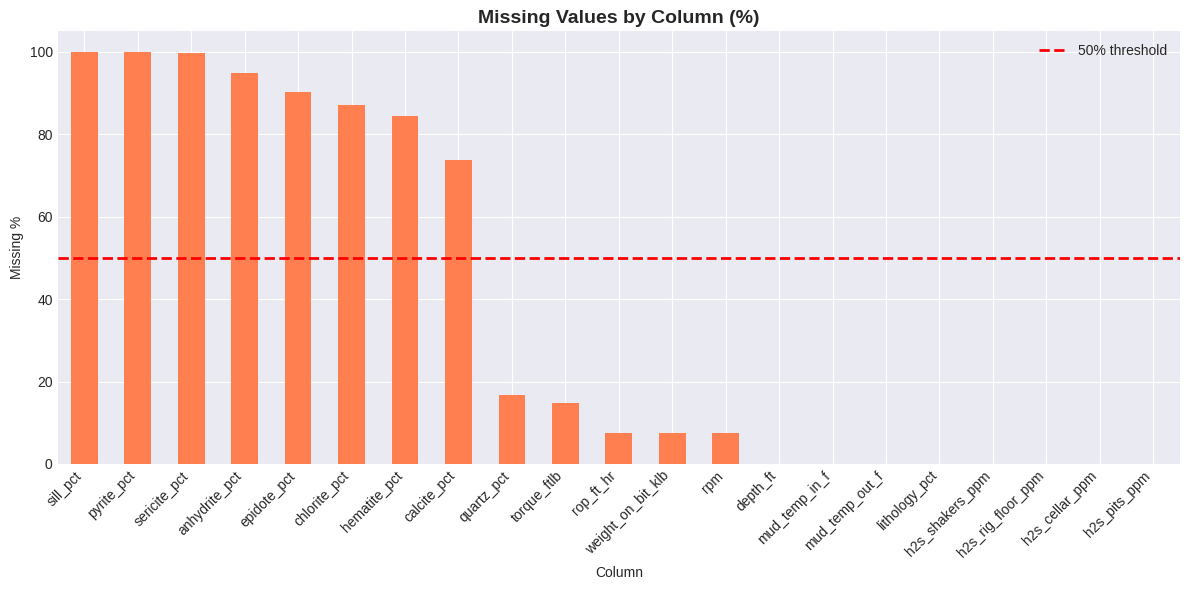


Columns with >50% missing data:
  - sill_pct: 100.0%
  - pyrite_pct: 99.9%
  - sericite_pct: 99.7%
  - anhydrite_pct: 94.9%
  - epidote_pct: 90.2%
  - chlorite_pct: 87.1%
  - hematite_pct: 84.4%
  - calcite_pct: 73.8%


In [10]:
# Calculate missing values
missing_stats = pd.DataFrame({
    'column': df_well.columns,
    'missing_count': df_well.isnull().sum().values,
    'missing_pct': (df_well.isnull().sum() / len(df_well) * 100).values,
    'dtype': df_well.dtypes.values
})

missing_stats = missing_stats.sort_values('missing_pct', ascending=False)

print("=" * 60)
print("MISSING VALUES ANALYSIS")
print("=" * 60)
print(missing_stats.to_string(index=False))

# Visualize missing values
fig, ax = plt.subplots(figsize=(12, 6))
missing_pct = (df_well.isnull().sum() / len(df_well) * 100).sort_values(ascending=False)
missing_pct.plot(kind='bar', color='coral', ax=ax)
ax.set_title('Missing Values by Column (%)', fontsize=14, fontweight='bold')
ax.set_xlabel('Column')
ax.set_ylabel('Missing %')
ax.axhline(y=50, color='red', linestyle='--', linewidth=2, label='50% threshold')
ax.legend()
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Identify high missing columns
high_missing = missing_stats[missing_stats['missing_pct'] > 50]
if not high_missing.empty:
    print(f"\nColumns with >50% missing data:")
    for col in high_missing['column']:
        pct = high_missing[high_missing['column'] == col]['missing_pct'].values[0]
        print(f"  - {col}: {pct:.1f}%")
else:
    print("\n[WARNING] No columns with >50% missing data")

## 8. Data Validation

Check for data quality issues:
- Negative values (physically impossible)
- Depth continuity
- Duplicate depths

In [11]:
print("=" * 60)
print("DATA VALIDATION")
print("=" * 60)

# 1. Check for negative values (physically impossible)
print("\n🔍 Checking for negative values (should be 0):")
negative_checks = {
    'weight_on_bit_klb': (df_well['weight_on_bit_klb'] < 0).sum(),
    'torque_ftlb': (df_well['torque_ftlb'] < 0).sum(),
    'rpm': (df_well['rpm'] < 0).sum(),
    'rop_ft_hr': (df_well['rop_ft_hr'] < 0).sum()
}

for col, count in negative_checks.items():
    status = "[OK]" if count == 0 else "[X]"
    print(f"  {status} {col}: {count} negative values")

# 2. Check depth continuity
print("\n🔍 Checking depth continuity:")
depth_diff = df_well['depth_ft'].diff()
expected_step = 1.0
irregular_steps = ((depth_diff != expected_step) & (depth_diff.notna())).sum()
print(f"  Expected step: {expected_step} ft")
print(f"  Irregular steps: {irregular_steps}")
if irregular_steps > 0:
    print(f"  ⚠️  Warning: Found {irregular_steps} irregular depth steps")
else:
    print(f"  [OK] All depth steps are regular")

# 3. Check for duplicate depths
print("\n🔍 Checking for duplicate depths:")
duplicates = df_well.duplicated(subset=['depth_ft']).sum()
print(f"  Duplicate depths: {duplicates}")
if duplicates > 0:
    print(f"  [WARNING]  Found {duplicates} duplicate depth values")
else:
    print(f"  [OK] No duplicate depths found")

# 4. Check mineral composition sum
print("\n🔍 Checking mineral composition:")
mineral_cols = [col for col in df_well.columns if '_pct' in col and col != 'lithology_pct']
mineral_sum = df_well[mineral_cols].sum(axis=1)
print(f"  Mineral sum statistics:")
print(f"    Mean: {mineral_sum.mean():.2f}%")
print(f"    Min: {mineral_sum.min():.2f}%")
print(f"    Max: {mineral_sum.max():.2f}%")
print(f"    Std: {mineral_sum.std():.2f}%")

# Count rows where sum is close to 100%
close_to_100 = ((mineral_sum >= 95) & (mineral_sum <= 105)).sum()
print(f"  Rows with sum 95-105%: {close_to_100} ({close_to_100/len(df_well)*100:.1f}%)")

DATA VALIDATION

🔍 Checking for negative values (should be 0):
  [OK] weight_on_bit_klb: 0 negative values
  [OK] torque_ftlb: 0 negative values
  [OK] rpm: 0 negative values
  [OK] rop_ft_hr: 0 negative values

🔍 Checking depth continuity:
  Expected step: 1.0 ft
  Irregular steps: 0
  [OK] All depth steps are regular

🔍 Checking for duplicate depths:
  Duplicate depths: 0
  [OK] No duplicate depths found

🔍 Checking mineral composition:
  Mineral sum statistics:
    Mean: 35.97%
    Min: 0.00%
    Max: 90.00%
    Std: 26.75%
  Rows with sum 95-105%: 0 (0.0%)


## 9. Quick Visualization

Basic plots to verify data loaded correctly.

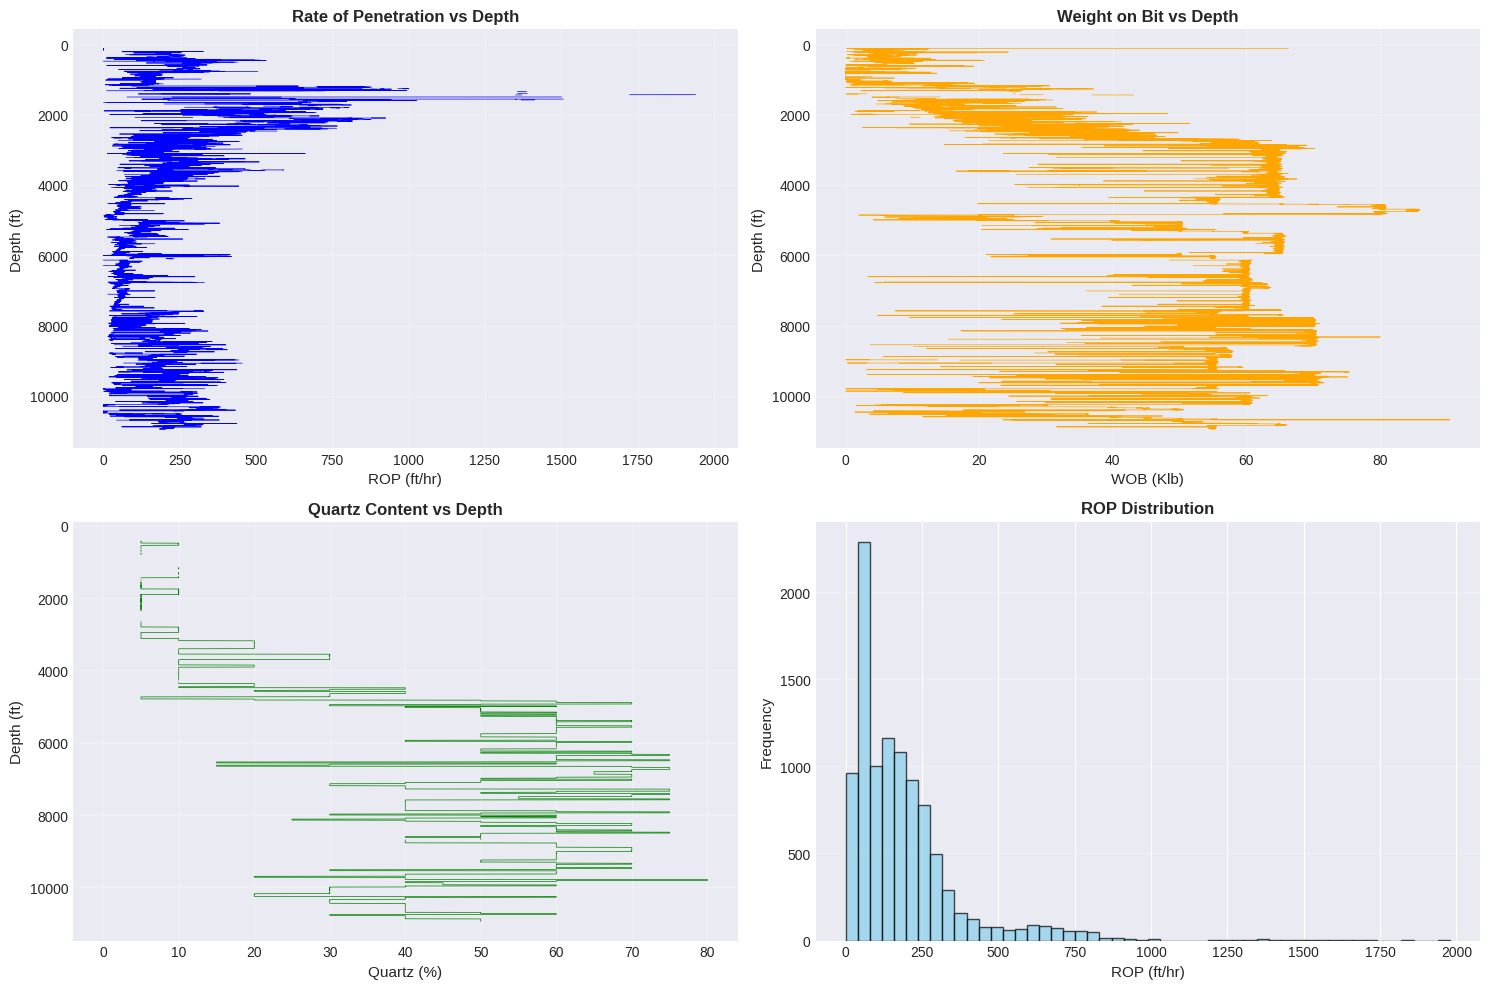

[OK] Quick visualization complete


In [12]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. ROP vs Depth
axes[0, 0].plot(df_well['rop_ft_hr'], df_well['depth_ft'], linewidth=0.5, color='blue')
axes[0, 0].set_xlabel('ROP (ft/hr)', fontsize=11)
axes[0, 0].set_ylabel('Depth (ft)', fontsize=11)
axes[0, 0].set_title('Rate of Penetration vs Depth', fontsize=12, fontweight='bold')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(True, alpha=0.3)

# 2. WOB vs Depth
axes[0, 1].plot(df_well['weight_on_bit_klb'], df_well['depth_ft'], linewidth=0.5, color='orange')
axes[0, 1].set_xlabel('WOB (Klb)', fontsize=11)
axes[0, 1].set_ylabel('Depth (ft)', fontsize=11)
axes[0, 1].set_title('Weight on Bit vs Depth', fontsize=12, fontweight='bold')
axes[0, 1].invert_yaxis()
axes[0, 1].grid(True, alpha=0.3)

# 3. Quartz % vs Depth
axes[1, 0].plot(df_well['quartz_pct'], df_well['depth_ft'], linewidth=0.5, color='green')
axes[1, 0].set_xlabel('Quartz (%)', fontsize=11)
axes[1, 0].set_ylabel('Depth (ft)', fontsize=11)
axes[1, 0].set_title('Quartz Content vs Depth', fontsize=12, fontweight='bold')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(True, alpha=0.3)

# 4. ROP distribution
axes[1, 1].hist(df_well['rop_ft_hr'].dropna(), bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('ROP (ft/hr)', fontsize=11)
axes[1, 1].set_ylabel('Frequency', fontsize=11)
axes[1, 1].set_title('ROP Distribution', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("[OK] Quick visualization complete")

## 10. Save Processed Data

Export DataFrame to CSV and save metadata for reproducibility.

In [13]:
# Define output paths
OUTPUT_CSV = '../data/processed/well_data_clean.csv'
OUTPUT_METADATA = '../data/processed/well_data_metadata.json'

# Save DataFrame to CSV
df_well.to_csv(OUTPUT_CSV, index=False)

# Create metadata dictionary
metadata = {
    'source_file': LAS_FILE_PATH,
    'processing_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'notebook': '01_data_loading.ipynb',
    'total_rows': int(len(df_well)),
    'total_columns': int(len(df_well.columns)),
    'depth_range_ft': {
        'min': float(df_well['depth_ft'].min()),
        'max': float(df_well['depth_ft'].max())
    },
    'null_value_convention': -999.25,
    'target_variable': 'rop_ft_hr',
    'feature_groups': {
        'operational': OPERATIONAL_FEATURES,
        'geological': GEOLOGICAL_FEATURES,
        'environmental': ENVIRONMENTAL_FEATURES
    },
    'columns': list(df_well.columns),
    'missing_values': {
        col: int(df_well[col].isnull().sum()) 
        for col in df_well.columns
    }
}

# Save metadata to JSON
with open(OUTPUT_METADATA, 'w') as f:
    json.dump(metadata, f, indent=2)

# Print summary
print("=" * 60)
print("DATA EXPORT SUMMARY")
print("=" * 60)
print(f"[OK] CSV saved to: {OUTPUT_CSV}")
print(f"[OK] Metadata saved to: {OUTPUT_METADATA}")
print(f"\n[INFO] Final DataFrame shape: {df_well.shape}")
print(f"[INFO] CSV file size: {os.path.getsize(OUTPUT_CSV) / 1024:.2f} KB")
print(f"[INFO] Metadata file size: {os.path.getsize(OUTPUT_METADATA) / 1024:.2f} KB")

print("\n" + "=" * 60)
print("[OK] DATA LOADING COMPLETE")
print("=" * 60)

DATA EXPORT SUMMARY
[OK] CSV saved to: ../data/processed/well_data_clean.csv
[OK] Metadata saved to: ../data/processed/well_data_metadata.json

[INFO] Final DataFrame shape: (10857, 21)
[INFO] CSV file size: 787.55 KB
[INFO] Metadata file size: 1.64 KB

[OK] DATA LOADING COMPLETE


## Summary

**Completed Tasks:**

- [X] Loaded LAS file using `welly`
- [X] Remapped non-standard mnemonics
- [X] Selected 20 relevant features
- [X] Renamed columns with descriptive names and units
- [X] Analyzed missing values
- [X] Validated data quality (negatives, duplicates, continuity)
- [X] Created quick visualizations
- [X] Exported clean DataFrame to CSV
- [X] Saved metadata for reproducibility

**Key Findings:**

- Total observations: ~10,857
- Features: 21 (1 depth + 20 features)
- Target variable: `rop_ft_hr`
- High missing values in some mineral columns (expected)

**Next Steps:**
1. Decide on missing value imputation strategy